### Base Experiments of Knowledge Distillation

In [2]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook
from collections import OrderedDict, defaultdict

###  1. Hinton + L2-penalization of parameters

In [129]:
# Own exceptions that deal with the AssertionError
class BaseValidationError(TypeError):
    pass
class NumInputMLPWrong(BaseValidationError):
    pass
class HiddenLayersMLPWrong(BaseValidationError):
    pass
class NumClassesMLPWrong(BaseValidationError):
    pass

In [130]:
# Create decorator to avoid repeating of a code
def own_assertionerror_exception(function):
    
    """
    function: decorator will be applied to this function(__init__)
    *args: passes variable of function
    **kwargs: keyworded variable of function
    
    """
    def wrapper(*args, **kwargs):
        
        for idx, keys, types, exception in zip( range(1,4),['num_input','hidden_layers','num_classes'],[int,list,int], 
                                         [NumInputMLPWrong, HiddenLayersMLPWrong, NumClassesMLPWrong ]):
            if keys in kwargs.keys():
                if isinstance(kwargs[keys],types) == False:
                    raise exception
            
            else:
                if isinstance(args[idx],types) ==  False:
                    raise exception
        
        result = function(*args,**kwargs)
        return result
    
    return wrapper
        

In [192]:
class MLP(torch.nn.Module):
     
    @own_assertionerror_exception
    def __init__(self, num_input, hidden_layers ,num_classes):
        super().__init__()
        
        self.num_input = num_input
        self.hidden_layers = hidden_layers
        self.num_classes = num_classes
        
                
        model_list = list()
        all_layers = [num_input] + hidden_layers + [num_classes]
        
        for num_layer, current_layer, next_layer in zip(range(len(all_layers)), all_layers, all_layers[1:]):
            model_list.extend([("linear_" + str(num_layer + 1), torch.nn.Linear(current_layer, next_layer)),
                               ("relu_" + str(num_layer   + 1), torch.nn.ReLU())])
        
        # remove final relu activation
        model_list.pop()
        
        self.net = torch.nn.Sequential(OrderedDict(model_list))
    
    
    # since  one __init__ can be in class there, then one can create alternative constructors 
    # classmethod for teacher
    @classmethod
    @own_assertionerror_exception
    def teacher(cls, num_input , hidden_layers, num_classes):
            
        return cls(num_input = num_input , hidden_layers = hidden_layers, num_classes = num_classes)
    
    
    # classmethod for student
    @classmethod
    @own_assertionerror_exception
    def student(cls, num_input, hidden_layers, num_classes):
            
        return cls(num_input = num_input , hidden_layers = hidden_layers,num_classes = num_classes )
    
        
    def forward(self,x):
        x = x.view(-1, self.num_input)
        return self.net(x)
    
    @property
    def __str__(self):
        return f"num_input is {self.num_input}, hidden_layers is {self.hidden_layers} and num_classes is {self.num_classes}"
    
    
    # for describing of NN without __repr__ better, then one can call model.parameters normally
    """
    def __repr__(self):
        text = f"num_input = {self.num_input}, hidden_layers = {self.hidden_layers} , num_classes = {self.num_classes}"
        return type(self).__name__ + "(" + text + ")"
    """
    
 
        

In [11]:
def plot_learning_curves(history):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)

    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='validation')

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='validation')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    plt.show()

In [12]:
def train_teacher(num_epochs,
                  model,
                  optimizer,
                  train_loader,
                  val_loader,
                  criterion,
                  device):
    
    history = defaultdict(lambda : defaultdict(list))
    for epoch in tqdm_notebook(range(num_epochs)):
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()
        
        model.requires_grad_(True)
        
        for x_batch, y_batch in tqdm_notebook(train_loader):
            
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch.long().to(device))
            
            loss.backward()
            optimizer.step()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        
        model.requires_grad_(False)
        
        with torch.no_grad():
            for x_batch, y_batch in tqdm_notebook(val_loader):
                
                x_batch,y_batch = x_batch.to(device),y_batch.to(device)
                
                logits = model(x_batch)
                loss = criterion(logits, y_batch.long().to(device))
                
                val_loss += np.sum(loss.detach().cpu().numpy())
                y_pred = logits.max(1)[1].detach().cpu().numpy()
                val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            val_loss /= len(val_loader)
            val_acc /= len(val_loader)
            history['loss']['val'].append(val_loss)
            history['acc']['val'].append(val_acc)
        
        clear_output()
                #print results after each epoch
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history     

In [13]:
train_val_dataset = torchvision.datasets.MNIST(root='./data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=torchvision.transforms.ToTensor(),download=True)

Files already downloaded
Files already downloaded


In [14]:
BATCH_SIZE = 64
TRAIN_AMOUNT = 50000
train_dataset, ignore_dataset ,val_dataset = torch.utils.data.random_split(train_val_dataset, [TRAIN_AMOUNT , 50000 - TRAIN_AMOUNT,10000])

 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Epoch 20 of 20 took 185.976s
  training loss (in-iteration): 	0.013750
  validation loss (in-iteration): 	0.135212
  training accuracy: 			99.64 %
  validation accuracy: 			97.72 %


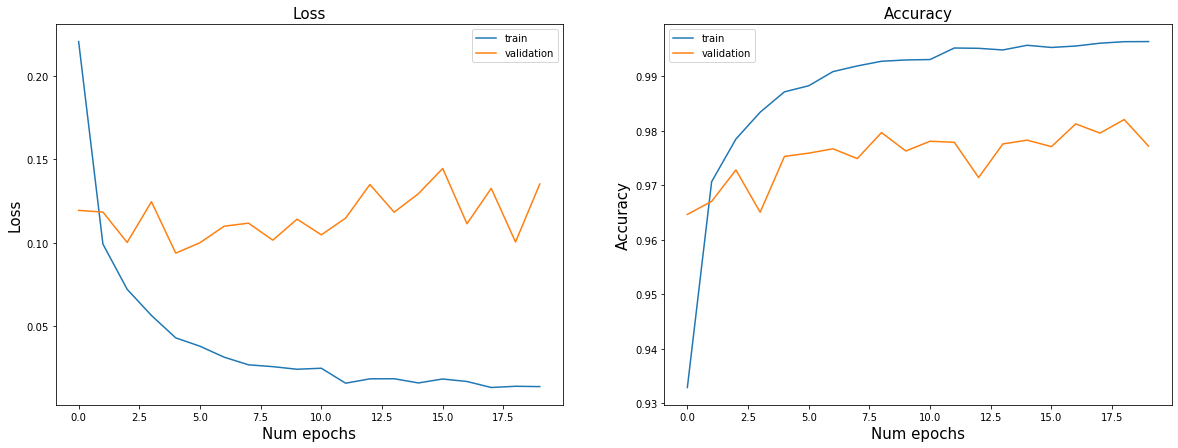

In [15]:
NUM_INPUT = 28*28
HIDDEN_TEACHER = [2*28*28, 2000, 500]
NUM_CLASSES = 10
DEVICE = 'cpu'
NUM_EPOCHS = 20
LR = 1e-3
CRITERION = torch.nn.CrossEntropyLoss()

teacher = MLP( NUM_INPUT , HIDDEN_TEACHER , NUM_CLASSES ).to(DEVICE)
teacher_optimizer = torch.optim.Adam(teacher.parameters(),lr=LR)
teacher, history_teacher = train_teacher(NUM_EPOCHS,teacher,teacher_optimizer,
                                        train_loader,val_loader, CRITERION, DEVICE )

In [16]:
teacher_trained = teacher
history_teacher_trained = history_teacher

In [134]:
def train_student_hinton(*args, **kwargs):
    
    history = defaultdict(lambda: defaultdict(list))
    for epoch in tqdm_notebook(range(kwargs['num_epochs'])):
        
        train_loss = 0
        train_acc =  0
        val_loss  =  0
        val_acc   =  0
        
        start_time = time.time()
        
        kwargs['student'].requires_grad_(True)
        kwargs['teacher'].requires_grad_(False)
        
        for x_batch,y_batch in tqdm_notebook(kwargs['train_loader']):
            x_batch,y_batch = x_batch.to(kwargs['device']), y_batch.to(kwargs['device'])
            
            kwargs['student_optimizer'].zero_grad()
            
            logits_teacher = kwargs['teacher'](x_batch).detach()
            logits_student = kwargs['student'](x_batch)
            
            loss_student = kwargs['criterion'](logits_student, y_batch.long().to(kwargs['device']))
            
            distillation_loss = torch.nn.KLDivLoss(reduction = 'none')(torch.nn.Softmax(dim=1)\
                                (logits_student/kwargs['temperature']) , torch.nn.Softmax(dim=1)\
                                (logits_teacher/kwargs['temperature'])).sum(1).mean()
            
            full_loss = 1*loss_student + 0.1*distillation_loss
            full_loss.backward()
            kwargs['student_optimizer'].step()
            
            train_loss += np.sum(full_loss.detach().cpu().numpy())
            y_pred = logits_student.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        
        train_loss /= len(kwargs['train_loader'])
        train_acc /=  len(kwargs['train_loader'])
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        
        kwargs['student'].requires_grad_(False)
        
        with torch.no_grad():
            for x_batch,y_batch in tqdm_notebook(kwargs['val_loader']):
                x_batch,y_batch = x_batch.to(kwargs['device']),y_batch.to(kwargs['device'])
                
                logits_student = kwargs['student'](x_batch).detach()
                logits_teacher =  kwargs['teacher'](x_batch).detach()
                
                loss_student = kwargs['criterion'](logits_student, y_batch.long().to(kwargs['device']))
                distillation_loss = torch.nn.KLDivLoss(reduction = 'none')(torch.nn.Softmax(dim=1)\
                                (logits_student/kwargs['temperature']) , torch.nn.Softmax(dim=1)\
                                (logits_teacher/kwargs['temperature'])).sum(1).mean()
                
                full_loss_val = 1*loss_student + 0.2*distillation_loss
                val_loss += np.sum(full_loss_val.detach().cpu().numpy())
                y_pred = logits_student.max(1)[1].detach().cpu().numpy()
                val_acc += np.mean(y_batch.cpu().numpy() == y_pred )
            
            val_loss /= len(kwargs['val_loader'])
            val_acc /= len(kwargs['val_loader'])
            history['loss']['val'].append(val_loss)
            history['acc']['val'].append(val_acc)
            
        clear_output()
            
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, kwargs['num_epochs'], time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return kwargs['student'], history

Epoch 20 of 20 took 156.105s
  training loss (in-iteration): 	-0.089428
  validation loss (in-iteration): 	-0.078345
  training accuracy: 			99.61 %
  validation accuracy: 			98.13 %


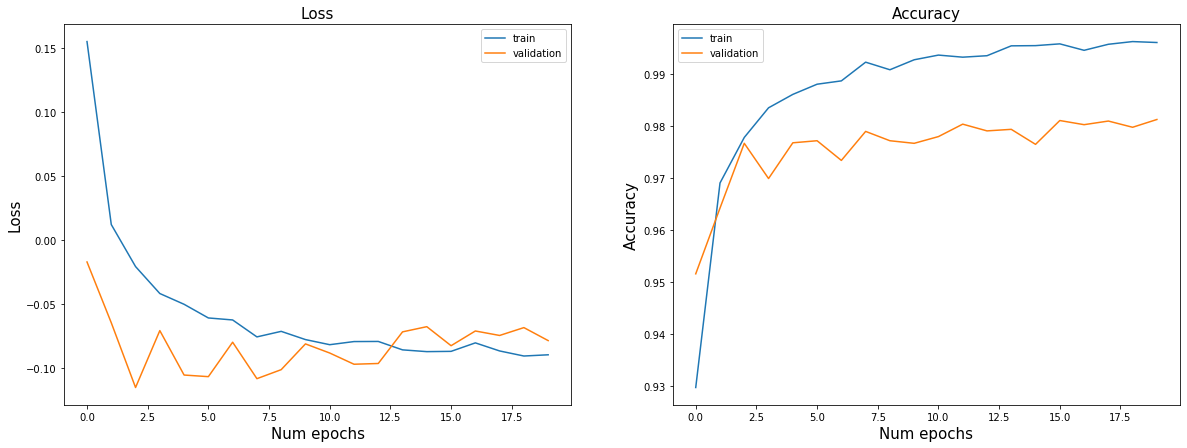

In [135]:
NUM_EPOCHS = 20
TEMPERATURE = 3
NUM_CLASSES = 10
HIDDEN_STUDENT = HIDDEN_TEACHER
DEVICE = 'cpu'
LR = 1e-3
student = MLP(NUM_INPUT,HIDDEN_STUDENT,NUM_CLASSES).to(DEVICE)
student_optimizer = torch.optim.Adam(student.parameters(),lr=LR)
trained_teacher = teacher
CRITERION = torch.nn.CrossEntropyLoss()


student, history_student = train_student_hinton(num_epochs = NUM_EPOCHS, student = student , teacher = trained_teacher,
                                        device = DEVICE, train_loader = train_loader, val_loader = val_loader,
                                        student_optimizer = student_optimizer, criterion = CRITERION, temperature = TEMPERATURE)

In [136]:
student_trained = student
history_student_trained = history_student

In [196]:
def train_student_hinton_modified(*args, **kwargs):
    
    history = defaultdict(lambda: defaultdict(list))
    for epoch in tqdm_notebook(range(kwargs['num_epochs'])):
        
        train_loss = 0
        train_acc =  0
        val_loss  =  0
        val_acc   =  0
        
        start_time = time.time()
        
        kwargs['student'].requires_grad_(True)
        kwargs['teacher'].requires_grad_(False)
        
        for x_batch,y_batch in tqdm_notebook(kwargs['train_loader']):
            x_batch,y_batch = x_batch.to(kwargs['device']), y_batch.to(kwargs['device'])
            
            kwargs['student_optimizer'].zero_grad()
            
            logits_teacher = kwargs['teacher'](x_batch).detach()
            logits_student = kwargs['student'](x_batch)
            
            loss_student = kwargs['criterion'](logits_student, y_batch.long().to(kwargs['device']))
            
            distillation_loss = torch.nn.KLDivLoss(reduction = 'none')(torch.nn.Softmax(dim=1)\
                                (logits_student/kwargs['temperature']) , torch.nn.Softmax(dim=1)\
                                (logits_teacher/kwargs['temperature'])).sum(1).mean()
            
            # parameters loss
            param_loss = torch.tensor([0.])
            for (name_student, param_student),(name_teacher, param_teacher) in zip(kwargs['student'].named_parameters(),
                                                                                  kwargs['teacher'].named_parameters()):
                if param_student.requires_grad:
                    param_loss += torch.norm( param_student.data - param_teacher.data )
                    
            
            full_loss = 1*loss_student + 0.1*distillation_loss + 0.1*param_loss
            full_loss.backward()
            kwargs['student_optimizer'].step()
            
            train_loss += np.sum(full_loss.detach().cpu().numpy())
            y_pred = logits_student.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        
        train_loss /= len(kwargs['train_loader'])
        train_acc /=  len(kwargs['train_loader'])
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        
        kwargs['student'].requires_grad_(False)
        
        with torch.no_grad():
            for x_batch,y_batch in tqdm_notebook(kwargs['val_loader']):
                x_batch,y_batch = x_batch.to(kwargs['device']),y_batch.to(kwargs['device'])
                
                logits_student = kwargs['student'](x_batch).detach()
                logits_teacher =  kwargs['teacher'](x_batch).detach()
                
                loss_student = kwargs['criterion'](logits_student, y_batch.long().to(kwargs['device']))
                distillation_loss = torch.nn.KLDivLoss(reduction = 'none')(torch.nn.Softmax(dim=1)\
                                (logits_student/kwargs['temperature']) , torch.nn.Softmax(dim=1)\
                                (logits_teacher/kwargs['temperature'])).sum(1).mean()
                
                # parameters loss
                param_loss = torch.tensor([0.])
                for (name_student,param_student),(name_teacher, param_teacher) in zip(kwargs['student'].named_parameters(),
                                                                                     kwargs['teacher'].named_parameters()):
                    if 'linear' in name_student:
                        param_loss += torch.norm(param_student.data - param_teacher.data)
                        
                
                
                
                full_loss_val = 1*loss_student + 0.2*distillation_loss + 0.1*param_loss
                
                val_loss += np.sum(full_loss_val.detach().cpu().numpy())
                y_pred = logits_student.max(1)[1].detach().cpu().numpy()
                val_acc += np.mean(y_batch.cpu().numpy() == y_pred )
            
            val_loss /= len(kwargs['val_loader'])
            val_acc /= len(kwargs['val_loader'])
            history['loss']['val'].append(val_loss)
            history['acc']['val'].append(val_acc)
            
        clear_output()
            
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, kwargs['num_epochs'], time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return kwargs['student'], history
        

Epoch 20 of 20 took 319.932s
  training loss (in-iteration): 	41.739818
  validation loss (in-iteration): 	41.969522
  training accuracy: 			99.63 %
  validation accuracy: 			98.13 %


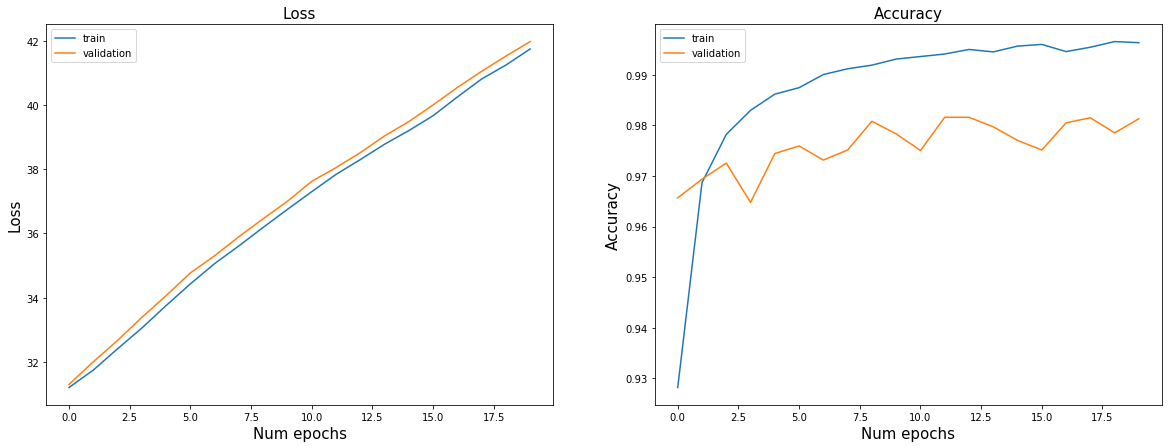

In [197]:
NUM_EPOCHS = 20
TEMPERATURE = 3
NUM_CLASSES = 10
HIDDEN_STUDENT = HIDDEN_TEACHER
DEVICE = 'cpu'
LR = 1e-3
student = MLP(NUM_INPUT,HIDDEN_STUDENT,NUM_CLASSES).to(DEVICE)
student_optimizer = torch.optim.Adam(student.parameters(),lr=LR)
trained_teacher = teacher
CRITERION = torch.nn.CrossEntropyLoss()


student, history_student = train_student_hinton_modified(num_epochs = NUM_EPOCHS, student = student , teacher = teacher,
                                        device = DEVICE, train_loader = train_loader, val_loader = val_loader,
                                        student_optimizer = student_optimizer, criterion = CRITERION, temperature = TEMPERATURE)

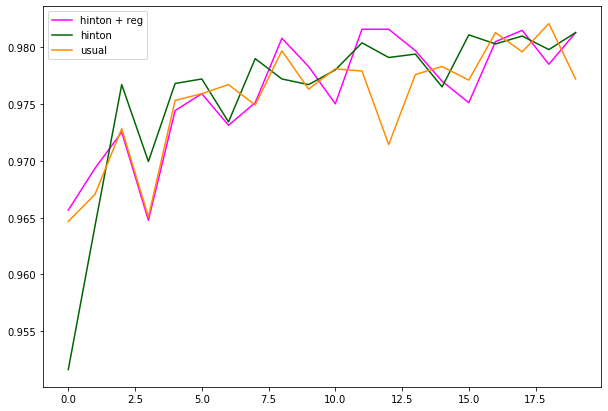

In [199]:
fig,ax = plt.subplots(figsize = (10,7))
ax.plot(history_student['acc']['val'], label = 'hinton + reg' , color= 'magenta')
ax.plot(history_student_trained['acc']['val'], label = 'hinton', color = 'darkgreen')
ax.plot(history_teacher_trained['acc']['val'], label = 'usual', color='darkorange')
ax.legend()
plt.show()